In [ ]:
import numpy as np
import pandas as pd

from data_proccessing import get_historical_ohlc
from pybit.unified_trading import HTTP
from api.constants import API_KEY, API_SECRET

In [12]:
session = HTTP(demo=True, api_key=API_KEY, api_secret=API_SECRET)
ohlc_m15 = get_historical_ohlc(session=session, symbol='BTCUSDT', interval='15')
ohlc_m5 = get_historical_ohlc(session=session, symbol='BTCUSDT', interval='5')
print(ohlc_m15.tail(2))

                    time      open      high       low     close   volume
4998 2025-09-29 11:30:00  111920.8  112069.8  111899.7  112059.6  347.544
4999 2025-09-29 11:45:00  112059.6  112069.0  112011.8  112023.7   43.569


In [3]:



# df["fractal"] = 0
# df["all_fractal_levels"] = 0 # can be also pd.NA
# high_fractal = (df.close.shift()>df.close.shift(2))&(df.close.shift()>df.close)
# low_fractal = (df.close.shift()<df.close.shift(2))&(df.close.shift()<df.close)
# df.loc[high_fractal,"fractal"] = 1
# df.loc[low_fractal ,"fractal"] = -1
# df.loc[high_fractal,"all_fractal_levels"] = dataframe[high_fractal]["high"]
# df.loc[low_fractal ,"all_fractal_levels"] = dataframe[high_fractal]["low"]

In [4]:
def detect_fvg(last_3_candels):

    fvg = 0
    fvg_top = 0
    fvg_bottom = 0

    high = last_3_candels['high'].values
    low = last_3_candels['low'].values

    if low[-1] > high[0]:

        fvg = 1
        fvg_top = low[-1]
        fvg_bottom = high[0]

    elif high[-1] < low[0]:
        
        fvg = -1
        fvg_top = low[0]
        fvg_bottom = high[-1]

    return fvg, fvg_top, fvg_bottom

In [5]:
from plotting import plotting_chart, plotting_chart_technicals

In [6]:
def detect_fractal(last_3_candels):
    
    fractal = 0
    fractal_level = 0

    high = last_3_candels['high'].values
    low = last_3_candels['low'].values

    if high[-2] > high[-1] and high[-2] > high[-3]:
        
        fractal += 1
        fractal_level = high[-2]

    if low[-2] < low[-1] and low[-2] < low[-3]:
            
            fractal -= 1
            fractal_level = low[-2]

    return fractal, fractal_level

In [7]:
all_fvg = [0, 0]
all_fvg_top = [0, 0]
all_fvg_bottom = [0, 0]
all_fractal = [0, 0]
all_fractal_levels = [0, 0]


for i in range(2, len(ohlc_m15)):

    last_3_candels_m5 = ohlc_m5.iloc[i-2:i+1]
    last_3_candels_m15 = ohlc_m15.iloc[i-2:i+1]
    fvg, fvg_top, fvg_bottom = detect_fvg(last_3_candels_m15)
    fractal, fractal_level = detect_fractal(last_3_candels_m5)
    all_fvg.append(fvg)
    all_fvg_top.append(fvg_top)
    all_fvg_bottom.append(fvg_bottom)
    all_fractal.append(fractal)
    all_fractal_levels.append(fractal_level)

all_fvg = pd.Series(all_fvg, name='fvg')
all_fvg_top = pd.Series(all_fvg_top, name='fvg_top')
all_fvg_bottom = pd.Series(all_fvg_bottom, name='fvg_bottom')
all_fractal = pd.Series(all_fractal, name='fractal')
all_fractal_levels = pd.Series(all_fractal_levels, name='fractal_levels')

ohlc = pd.concat([ohlc_m15, all_fvg, all_fvg_top, all_fvg_bottom, all_fractal, all_fractal_levels], axis=1)

In [8]:
def detect_bos(df):
    bos = [0, 0]
    bos_level = [np.nan, np.nan]
    bos_fractal_index = [np.nan, np.nan]
    bos_fractal_time = [pd.NaT, pd.NaT]

    last_high_fractal = np.nan
    last_high_idx = np.nan
    last_high_time = pd.NaT

    last_low_fractal = np.nan
    last_low_idx = np.nan
    last_low_time = pd.NaT

    for i in range(2, len(df)):
        prev = df.iloc[i - 1]

        if prev['fractal'] == 1:
            last_high_fractal = prev['fractal_levels']
            last_high_idx = i - 1
            last_high_time = prev['time']
        elif prev['fractal'] == -1:
            last_low_fractal = prev['fractal_levels']
            last_low_idx = i - 1
            last_low_time = prev['time']

        candle = df.iloc[i]
        body_high = max(candle['open'], candle['close'])
        body_low = min(candle['open'], candle['close'])

        signal = 0
        level = np.nan
        source_idx = np.nan
        source_time = pd.NaT

        if not np.isnan(last_high_fractal) and body_low > last_high_fractal:
            signal = 1
            level = last_high_fractal
            source_idx = last_high_idx
            source_time = last_high_time
            last_high_fractal = np.nan
            last_high_idx = np.nan
            last_high_time = pd.NaT

        elif not np.isnan(last_low_fractal) and body_high < last_low_fractal:
            signal = -1
            level = last_low_fractal
            source_idx = last_low_idx
            source_time = last_low_time
            last_low_fractal = np.nan
            last_low_idx = np.nan
            last_low_time = pd.NaT

        bos.append(signal)
        bos_level.append(level)
        bos_fractal_index.append(source_idx)
        bos_fractal_time.append(source_time)

    df['bos'] = bos
    df['bos_level'] = bos_level
    df['bos_fractal_index'] = bos_fractal_index
    df['bos_fractal_time'] = bos_fractal_time
    return df

In [10]:
class FractalFVGScanner:

    def __init__(self, m5_df, m15_df, *, fvg_window=3):

        self.m5_df = m5_df.copy()
        self.m5_df['time'] = pd.to_datetime(self.m5_df['time'])
        self.m5_df.sort_values('time', inplace=True)
        self.m5_df.set_index('time', inplace=True)

        self.m15_df = m15_df.copy()
        self.m15_df['time'] = pd.to_datetime(self.m15_df['time'])
        self.m15_df.sort_values('time', inplace=True)
        self.m15_df.set_index('time', inplace=True)

        self.fvg_window = int(fvg_window)
        self.matches = []

        self.high_fr_state = None
        self.low_fr_state = None
        self.consumed_fvg_ids = set()
    

    def _build_m15_fvg(self):
        
        records = []
        for i in range(2, len(self.m15_df)):
            block = self.m15_df.iloc[i-2:i+1]
            direction, top, bottom = detect_fvg(block)
            if direction == 0:
                continue

            last_bar_time = block.index[-1]
            search_start = last_bar_time
            search_end = search_start + pd.Timedelta(minutes=60)
            
            records.append({
                'fvg_id': len(records),
                'direction': direction,
                'top': top,
                'bottom': bottom,
                'time': last_bar_time,
                'search_start': search_start,
                'search_end': search_end,})
            
        self.m15_fvg = pd.DataFrame(records)
        if self.m15_fvg.empty:
            return
        
        self.m15_fvg.set_index('fvg_id', inplace=True, drop=False)

    def _build_m5_fractals(self):
        
        records = []
        for i in range(2, len(self.m5_df)):

            block = self.m5_df.iloc[i-2:i+1]
            direction, level = detect_fractal(block)
            if direction == 0:
                continue
            middle_time = block.index[-2]
            records.append({
                'fractal_id': len(records),
                'direction': direction,
                'level': level,
                'time': middle_time,
                'type': 'high' if direction == 1 else 'low',})
            
        self.m5_fractals = pd.DataFrame(records)
        self.m5_df['fractal'] = 0
        self.m5_df['fractal_level'] = np.nan
        self.m5_df['fractal_id'] = np.nan

        for _, row in self.m5_fractals.iterrows():
            ts = row['time']
            self.m5_df.at[ts, 'fractal'] = row['direction']
            self.m5_df.at[ts, 'fractal_level'] = row['level']
            self.m5_df.at[ts, 'fractal_id'] = row['fractal_id']

    def _fr_to_fvg(self):
        
        self.m5_df['active_fvg_id'] = np.nan
        if getattr(self, 'm15_fvg', pd.DataFrame()).empty:
            return
        
        for _, row in self.m15_fvg.iterrows():
            mask = ((self.m5_df.index >= row['search_start']) & (self.m5_df.index <= row['search_end']))
            self.m5_df.loc[mask, 'active_fvg_id'] = row['fvg_id']

    def _reset_states(self):
        self.high_fr_state = None
        self.low_fr_state = None

    def _scan_long(self):

        if 'active_fvg_id' not in self.m5_df.columns:
            return
        
        self.m5_df['tracked_high'] = np.nan
        self.m5_df['tracked_low'] = np.nan
        self.m5_df['bos'] = 0
        self.m5_df['bos_level'] = np.nan
        self.m5_df['bos_fractal_index'] = np.nan
        self.m5_df['bos_fractal_time'] = pd.NaT


        active_fvg = None

        for ts, candle in self.m5_df.iterrows():
            raw_fvg_id =candle['active_fvg_id']
            if pd.isna(raw_fvg_id):
                active_fvg = None
                self._reset_states()
                continue
        
            fvg_id = int(raw_fvg_id)

            if fvg_id in self.consumed_fvg_ids:
                self._reset_states()
                continue

            if active_fvg is None or active_fvg['fvg_id'] != fvg_id:
                row = self.m15_fvg.loc[fvg_id]
                active_fvg = {
                    'fvg_id': row['fvg_id'],
                    'direction': row['direction'],
                    'top': row['top'],
                    'bottom': row['bottom'],
                    'time': row['time'],
                    'search_start': row['search_start'],
                    'search_end': row['search_end'],
                    }
                
                self._reset_states()

            if active_fvg['direction'] != 1:
                continue
            if ts < active_fvg['search_start'] or ts > active_fvg['search_end']:
                continue

            fractal_dir = candle['fractal']
            level = candle['fractal_level']
            fractal_id = candle['fractal_id']

            if fractal_dir == 1 and pd.notna(level) and level > active_fvg['top']:
                self.high_fr_state = {
                    'time': ts,
                    'level': float(level),
                    'fractal_id': fractal_id}
                self.low_fr_state = None

            elif fractal_dir == -1 and self.high_fr_state and pd.notna(level):
                if active_fvg['bottom'] <= level <= active_fvg['top']:
                    self.low_fr_state = {
                        'time': ts,
                        'level': float(level),
                        'fractal_id': int(fractal_id) if pd.notna(fractal_id) else None,}   
                else:
                    self.low_fr_state = None
            
            self.m5_df.at[ts, 'tracked_high'] = self.high_fr_state['level'] if self.high_fr_state else np.nan
            self.m5_df.at[ts, 'tracked_low'] = self.low_fr_state['level'] if self.low_fr_state else np.nan

            if self.high_fr_state and self.low_fr_state and candle['close'] > self.high_fr_state['level']:
                fr_time = self.high_fr_state['time']
                fr_idx = self.m5_df.index.get_loc(fr_time)

                self.m5_df.at[ts, 'bos'] = 1
                self.m5_df.at[ts, 'bos_level'] = self.high_fr_state['level']
                self.m5_df.at[ts, 'bos_fractal_time'] = fr_time
                self.m5_df.at[ts, 'bos_fractal_index'] = fr_idx
                self.matches.append({
                    'direction': 'long',
                    'fvg_id': active_fvg['fvg_id'],
                    'fvg_start': active_fvg['search_start'],
                    'fvg_end': active_fvg['search_end'],
                    'high_fractal_id': self.high_fr_state['fractal_id'],
                    'high_fractal_time': self.high_fr_state['time'],
                    'high_fractal_level': self.high_fr_state['level'],
                    'low_fractal_id': self.low_fr_state['fractal_id'],
                    'low_ractal_time': self.low_fr_state['time'],
                    'low_fractal_level': self.low_fr_state['level'],
                    'bos_time': ts,
                    'bos_close': candle['close'],})
                self.consumed_fvg_ids.add(active_fvg['fvg_id'])
                active_fvg = None
                self._reset_states()
            continue
    
    def run_long(self):

        self._build_m15_fvg()
        self._build_m5_fractals()
        self._fr_to_fvg()
        self._scan_long()
        return pd.DataFrame(self.matches)

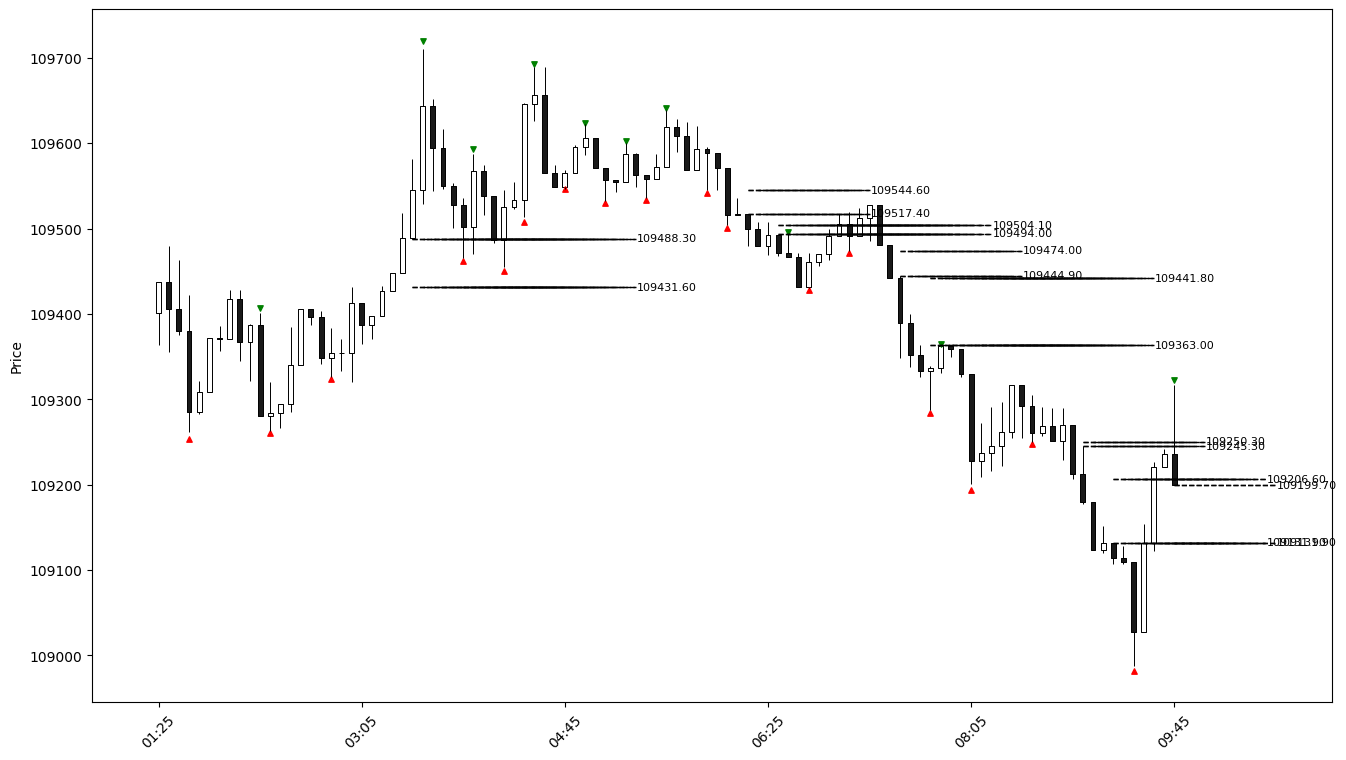

In [11]:
scanner = FractalFVGScanner(ohlc_m5, ohlc_m15)
matches = scanner.run_long()

base = scanner.m5_df.reset_index()

df_plot = base.copy()
df_plot['fractal'] = base['fractal'].fillna(0).astype(int).to_numpy()
df_plot['fractal_levels'] = base['fractal_level'].to_numpy()
df_plot['tracked_high'] = base['tracked_high'].to_numpy()
df_plot['tracked_low'] = base['tracked_low'].to_numpy()

df_plot['bos'] = base['bos'].fillna(0).astype(int).to_numpy()
df_plot['bos_level'] = base['bos_level'].to_numpy()
df_plot['bos_fractal_index'] = base.get('bos_fractal_index', pd.Series(np.nan, index=base.index)).to_numpy()
df_plot['bos_fractal_time'] = base.get('bos_fractal_time', pd.Series(pd.NaT, index=base.index)).to_numpy()

df_plot['fvg'] = 0
df_plot['fvg_top'] = np.nan
df_plot['fvg_bottom'] = np.nan
df_plot['active_fvg_id'] = base.get('active_fvg_id', pd.Series(np.nan, index=base.index)).to_numpy()

mask = ~pd.isna(df_plot['active_fvg_id'])
if mask.any() and not scanner.m15_fvg.empty:
    ids = df_plot.loc[mask, 'active_fvg_id'].astype(int)
    df_plot.loc[mask, 'fvg'] = ids.map(scanner.m15_fvg['direction'])
    df_plot.loc[mask, 'fvg_top'] = ids.map(scanner.m15_fvg['top'])
    df_plot.loc[mask, 'fvg_bottom'] = ids.map(scanner.m15_fvg['bottom'])

plotting_chart_technicals(df_plot, 4300, 4400)

